In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import num_features_model
import faiss

In [2]:
mean, std = torch.tensor(imagenet_stats)

class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])


In [4]:
class SiamImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        fn = self.items[i]
        fn1, fn2 = self.items[i]
        img1 = super().open(fn1)
        img2 = super().open(fn2)
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_folder(cls, path):
        lst = []
        items = []
        for each_dir in path.iterdir():
            class_files = []
            for file in each_dir.glob("*"):
                class_files.append(file)
            lst.append(class_files)
        for i, class_lst in enumerate(lst):
            # Generate dataset with same no of classes
            for j, img in enumerate(class_lst):
                rand_no = random.randint(0, len(class_lst)-1)
                while rand_no == j:
                    rand_no = random.randint(0, len(class_lst)-1)
                items.append([img, class_lst[rand_no]])
            # Generate dataset with different no of classes            
            other_images = []
            for k, x in enumerate(lst):
                if k == i:
                    continue
                other_images.extend(x)
            for j, img in enumerate(class_lst):
                rand_no = random.randint(0, len(other_images)-1)
                items.append([img, other_images[rand_no]])
                
        return cls(items)

In [39]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet34, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        #self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        #self.head = learner.create_head(num_features_model(self.body), self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        #self.cnn = nn.Sequential(self.body, self.head)
        self.cnn = create_cnn_model(self.arch, emb_sz, cut=None, pretrained=True, lin_ftrs=lin_ftrs, ps=self.ps, bn_final=self.bn_final)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [132]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()


In [41]:
gen_label = lambda x: 1 if str(x[0]).split('/')[-2] == str(x[1]).split('/')[-2] else 0
#gen_label = lambda x: 0 if str(x[0]).split('/')[-2] == str(x[1]).split('/')[-2] else 1

In [42]:
PATH = Path("/home/sairahul/myfiles/fastai_cmd/datasets/cifar10")

data = (SiamImageList.from_folder(path=PATH/'train')
                    .split_by_rand_pct()
                    .label_from_func(gen_label, label_cls=FloatList)
                    .databunch(bs=512))

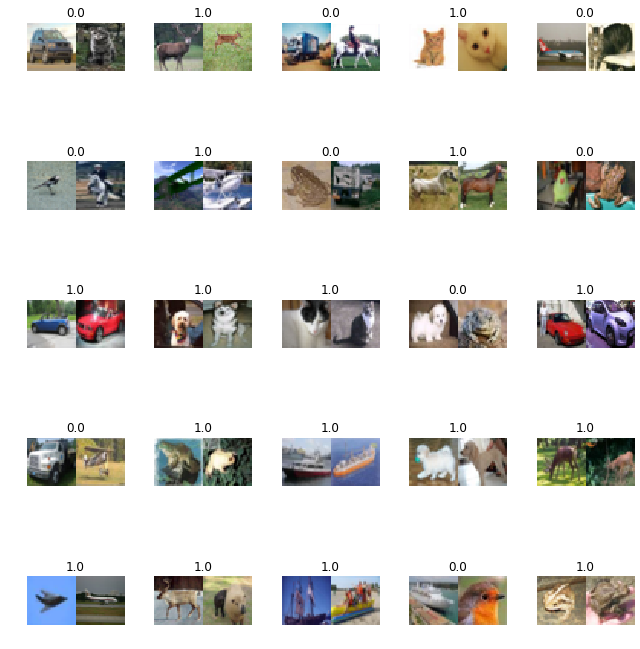

In [43]:
data.show_batch(5)

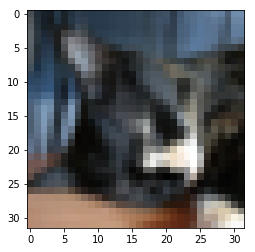

In [11]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))


In [133]:
def acc_siamese(preds, targs):
    s = np.zeros(targs.shape)
    import pdb; pdb.set_trace()
    p = np.where(preds > 0.5)[0]
    s[p] = 1
    return (s==targs.cpu().numpy()).mean()

In [134]:
def get_learner():
    model = SiameseNet().cuda()
    apply_init(model.cnn[1], nn.init.kaiming_normal_)
    loss_func=ContrastiveLoss().cuda()
    siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()), layer_groups=[model.cnn[0], model.cnn[1]])
    siam_learner.metrics=[acc_siamese]
    return siam_learner
siam_learner = get_learner()

In [123]:
siam_learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


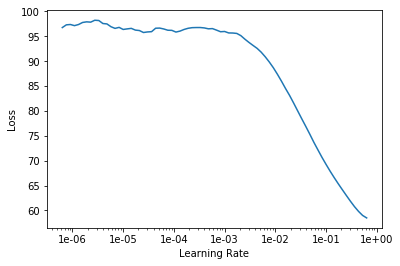

In [135]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [136]:
siam_learner.fit_one_cycle(20, slice(1*1e-2), div_factor=30., pct_start=0.9, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,acc_siamese,time


> <ipython-input-133-bbdb6be20529>(4)acc_siamese()
-> p = np.where(preds > 0.5)[0]
(Pdb) l
  1  	def acc_siamese(preds, targs):
  2  	    s = np.zeros(targs.shape)
  3  	    import pdb; pdb.set_trace()
  4  ->	    p = np.where(preds > 0.5)[0]
  5  	    s[p] = 1
  6  	    return (s==targs.cpu().numpy()).mean()
[EOF]
(Pdb) p targs
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 0., 1., 1

BdbQuit: 

In [56]:
siam_learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


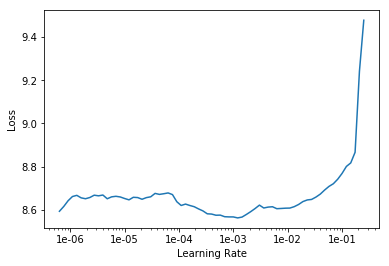

In [57]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [58]:
siam_learner.fit_one_cycle(15, slice(1*1e-3), div_factor=20., pct_start=0.7, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,time
0,8.528687,8.571882,00:24
1,8.374180,8.409978,00:24
2,8.175603,8.245271,00:24
3,8.031292,8.089479,00:24
4,7.820657,7.960218,00:24
5,7.664885,7.823845,00:24
6,7.510836,7.720475,00:24
7,7.347804,7.622061,00:24
8,7.159836,7.597631,00:24
9,7.023668,7.603153,00:24


In [60]:
siam_learner.fit_one_cycle(4, slice(1*1e-4), div_factor=20., pct_start=0.6, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,time
0,6.953282,7.600152,00:24
1,6.983388,7.589084,00:24
2,6.977993,7.585802,00:24
3,6.917920,7.588837,00:24


In [61]:
def extract_features(model, dirname, batch_size=512):
    dirname = Path(dirname)
    allfiles = [each_file for each_file in dirname.glob("*/*")]
    image_features = []
    for i in range(0, len(allfiles), batch_size):
        batch_files = allfiles[i:i+batch_size]
        
        img_batch = []
        for img in batch_files:
            img = open_image(img)
            img_batch.append(img.data)
        
        img_batch = torch.stack(img_batch, 0)
        features = model.get_embedding(img_batch.cuda())
        features = features.cpu()
        
        for img, feature in zip(batch_files, features):
            image_features.append(feature.flatten().numpy())
    
    return allfiles, np.stack(image_features, axis=0)

In [62]:
def display_closest(index, query_index, files, image_features):
    get_lbl = lambda fn: str(fn).split('/')[-2]

    dists, indexes = index.search(image_features[query_index][None,:], 12)

    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    fn = files[query_index]
    ax = axes[0][0]
    
    show_image(open_image(fn), ax=ax)
    axes[0][0].set_title(get_lbl(fn))
    for ax in axes[0][1:]:
        ax.axis('off')
    for i,ax in enumerate(axes.flat[4:]):
        fn = files[indexes[0][i]]
        show_image(open_image(fn), ax=ax)
        ax.set_title(get_lbl(fn))

In [114]:
siam_learner.model.eval()
for param in siam_learner.model.parameters():
    param.requires_grad = False

In [115]:
new_files, new_image_features = extract_features(siam_learner.model, PATH/"train")

In [96]:
img_feat = -1 * new_image_features

In [74]:
#new_index = faiss.IndexFlatL2(128)
new_index = faiss.IndexFlatIP(128)
#new_index.add(new_image_features)
new_index.add(img_feat)

In [116]:
nlist = 100  # number of clusters
quantiser = faiss.IndexFlatL2(128)
index = faiss.IndexIVFFlat(quantiser, 128, nlist, faiss.METRIC_L2)
#index = faiss.IndexIVFFlat(quantiser, 128, nlist, faiss.METRIC_INNER_PRODUCT)

In [117]:
index.is_trained

False

In [118]:
index.train(new_image_features)

In [119]:
index.add(new_image_features)

In [29]:
img_feat[0]

array([0.985557, 1.043177, 1.003812, 1.002703, ..., 0.998993, 1.001434, 0.989511, 1.010807], dtype=float32)

In [30]:
new_image_features[0]

array([ 0.014443, -0.043177, -0.003812, -0.002703, ...,  0.001007, -0.001434,  0.010489, -0.010807], dtype=float32)

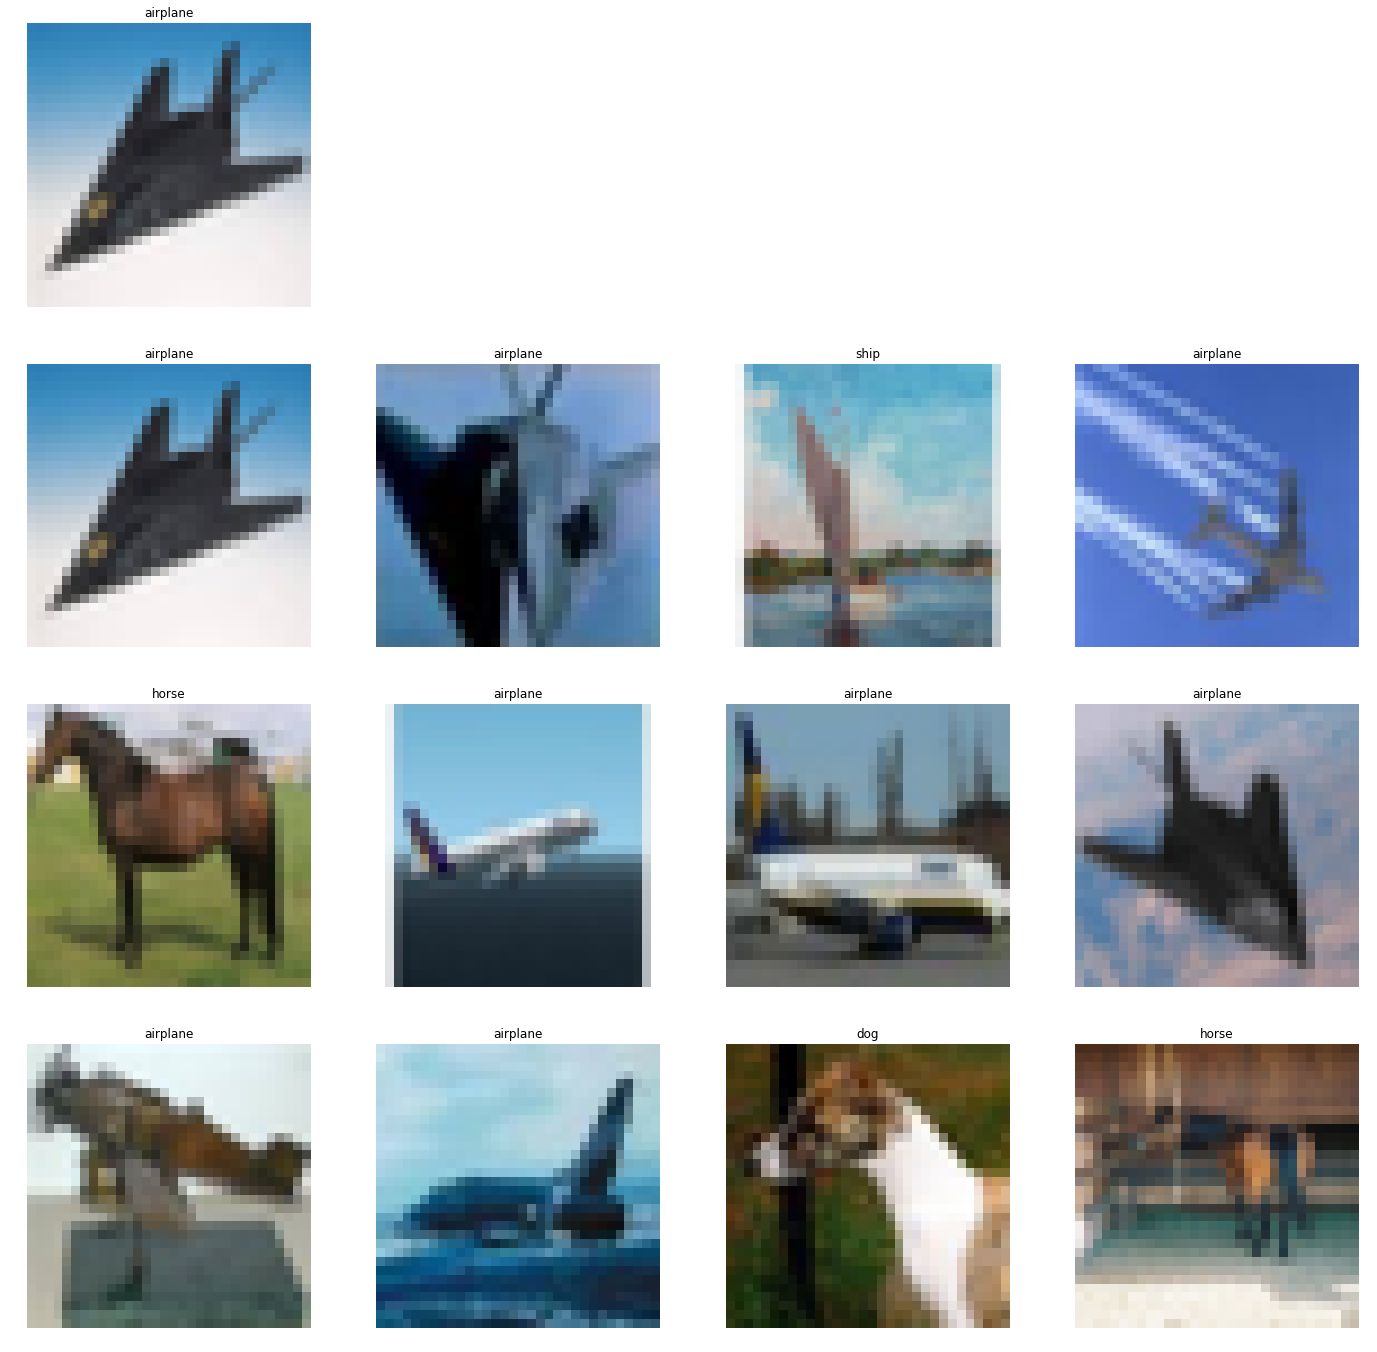

In [120]:
#display_closest(new_index, 5001, new_files, new_image_features)
display_closest(index, 0, new_files, new_image_features)

# References 

* http://afitts.github.io/2018/12/03/humpback-siamese/
* https://medium.com/@e_net4/taking-the-long-road-part-1-97e6e41f6b05